# Analysis of differentially expressed genes from scale-down experiments with substrate and/or oxygen oscillations

## Imports

In [3]:
from pymodulon.core import IcaData
from pymodulon import example_data
from pymodulon.io import save_to_json, load_json_model
from pymodulon.example_data import load_ecoli_data
from pymodulon.plotting import *
import pymodulon
from pymodulon.enrichment import *

In [4]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors
from matplotlib import cm
from matplotlib.offsetbox import AnchoredText
from mpl_toolkits.axes_grid1 import make_axes_locatable

from matplotlib.patches import Patch
from matplotlib.patches import Circle
from matplotlib.lines import Line2D

# import venn

In [5]:
# Loading it again (if resuming work)
ica_data_ddb = load_json_model("../data/ica_data/ica_data.json")
ica_data = load_json_model("../data/ica_data/ecoli_p1k.json")

## Loading DEGs

In [6]:
def replace_p_value_zeros(deg_df):
    padj_values = list(deg_df.padj)
    new_padj_values = []
    min_replacement = deg_df[deg_df.padj != 0].padj.min() * 0.1
    
    for val in padj_values:
        if val == 0:
            new_padj_values.append(min_replacement)
        elif val == np.nan:
            new_padj_values.append(np.nan)
        else:
            new_padj_values.append(val)
            
    deg_df.padj = new_padj_values
    
    return deg_df

In [7]:
O_osc_vs_Control_degs = pd.read_csv("../data/processed_RNA-seq_data/DESeq_res_O2_sd_O_osc_vs_Control.csv", index_col=0)
S_osc_famine_vs_feast_degs = pd.read_csv("../data/processed_RNA-seq_data/DESeq_res_O2_sd_S_osc_famine_vs_feast.csv", index_col=0)
S_osc_vs_Control_degs = pd.read_csv("../data/processed_RNA-seq_data/DESeq_res_O2_sd_S_osc_vs_Control.csv", index_col=0)
SO_osc_vs_Control_degs = pd.read_csv("../data/processed_RNA-seq_data/DESeq_res_O2_sd_SO_osc_vs_Control.csv", index_col=0)
S_osc_famine_vs_Control_degs = pd.read_csv("../data/processed_RNA-seq_data/DESeq_res_O2_sd_S_famine_vs_Control.csv", index_col=0)
S_osc_feast_vs_Control_degs = pd.read_csv("../data/processed_RNA-seq_data/DESeq_res_O2_sd_S_feast_vs_Control.csv", index_col=0)

O_osc_vs_Control_degs = replace_p_value_zeros(O_osc_vs_Control_degs)
S_osc_famine_vs_feast_degs = replace_p_value_zeros(S_osc_famine_vs_feast_degs)
S_osc_vs_Control_degs = replace_p_value_zeros(S_osc_vs_Control_degs)
SO_osc_vs_Control_degs = replace_p_value_zeros(SO_osc_vs_Control_degs)
S_osc_famine_vs_Control_degs = replace_p_value_zeros(S_osc_famine_vs_Control_degs)
S_osc_feast_vs_Control_degs = replace_p_value_zeros(S_osc_feast_vs_Control_degs)

# Define Functions

In [8]:
def calculate_DEG_enrichments(deg_dataframe, deg_fold_change_threshold=2.0, fdr=10e-5):
    
    regulator_enrichment_df = pd.DataFrame()
    cog_enrichment_df = pd.DataFrame()
    deg_results_df = pd.DataFrame()
    
    deg_df = deg_dataframe.copy()
    
        
    # select insignificant genes
    ############################
    ns_df = deg_df[((deg_df["padj"] > fdr) | ((deg_df["log2FoldChange"] > -np.log2(deg_fold_change_threshold)) & (deg_df["log2FoldChange"] < np.log2(deg_fold_change_threshold))))]
        
    # select up genes
    #################
    up_df = deg_df[((deg_df["padj"] <= fdr) & (deg_df["log2FoldChange"] >= np.log2(deg_fold_change_threshold)))]
    up_df["direction"] = "up"
        
    # select down genes
    ###################
    down_df = deg_df[((deg_df["padj"] <= fdr) & (deg_df["log2FoldChange"] <= -np.log2(deg_fold_change_threshold)))]
    down_df["direction"] = "down"
    
    deg_results_df = pd.concat([deg_results_df, pd.concat([down_df, up_df])])
        
    # Calucalte enrichments
    #######################
          
    ### COGs ############################
    #####################################

    cog_list = list(ica_data.gene_table.COG.unique())

    for cog in cog_list:

        all_genes = list(ica_data.gene_table.index.unique())
        gene_set_down_temp = list(down_df.index)
        gene_set_down = []
        for gene_id in gene_set_down_temp:
            if gene_id in all_genes:
                gene_set_down.append(gene_id)

        gene_set_up_temp = list(up_df.index)
        gene_set_up = []
        for gene_id in gene_set_up_temp:
            if gene_id in all_genes:
                gene_set_up.append(gene_id)

        target_genes = list(ica_data.gene_table[ica_data.gene_table.COG == cog].index)

        for direction in ["up", "down"]:

            gene_set = vars()["gene_set_" + direction]

            df1 = compute_enrichment(gene_set, target_genes, all_genes)

            df = pd.DataFrame()
            df = pd.concat([df,df1]).T
            df["COG"] = cog
            df["Direction"] = direction
            df["All_genes"] = len(all_genes)

            cog_enrichment_df = pd.concat([cog_enrichment_df,df])
            
    ### TRN #############################
    #####################################
    
    for direction in ["up", "down"]:
        
        gene_set = vars()["gene_set_" + direction]
        
        df1 = compute_trn_enrichment(gene_set, all_genes, ica_data.trn)
        df1["Direction"] = direction
        
        regulator_enrichment_df = pd.concat([regulator_enrichment_df,df1])
        

    cog_enrichment_df.index = range(0,len(cog_enrichment_df))
    cog_enrichment_df["Fold_enrichment"] = (cog_enrichment_df["TP"]/cog_enrichment_df["gene_set_size"])/(cog_enrichment_df["target_set_size"]/cog_enrichment_df["All_genes"])
    
    return regulator_enrichment_df, cog_enrichment_df, deg_results_df

# Calculate COG and TRN enrichments

In [7]:
a, b, c = calculate_DEG_enrichments(O_osc_vs_Control_degs, deg_fold_change_threshold=2.0, fdr=10e-5)
a.to_excel("../data/processed_RNA-seq_data/O_osc_vs_Control_degs_TRN_enrichment.xlsx")
b.to_excel("../data/processed_RNA-seq_data/O_osc_vs_Control_degs_COG_enrichment.xlsx")
c.to_excel("../data/processed_RNA-seq_data/O_osc_vs_Control_degs_DEG_results.xlsx")

a, b, c = calculate_DEG_enrichments(S_osc_famine_vs_feast_degs, deg_fold_change_threshold=2.0, fdr=10e-5)
a.to_excel("../data/processed_RNA-seq_data/S_osc_famine_vs_feast_degs_TRN_enrichment.xlsx")
b.to_excel("../data/processed_RNA-seq_data/S_osc_famine_vs_feast_degs_COG_enrichment.xlsx")
c.to_excel("../data/processed_RNA-seq_data/S_osc_famine_vs_feast_degs_DEG_results.xlsx")

a, b, c = calculate_DEG_enrichments(S_osc_vs_Control_degs, deg_fold_change_threshold=2.0, fdr=10e-5)
a.to_excel("../data/processed_RNA-seq_data/S_osc_vs_Control_degs_TRN_enrichment.xlsx")
b.to_excel("../data/processed_RNA-seq_data/S_osc_vs_Control_degs_COG_enrichment.xlsx")
c.to_excel("../data/processed_RNA-seq_data/S_osc_vs_Control_degs_DEG_results.xlsx")

a, b, c = calculate_DEG_enrichments(SO_osc_vs_Control_degs, deg_fold_change_threshold=2.0, fdr=10e-5)
a.to_excel("../data/processed_RNA-seq_data/SO_osc_vs_Control_degs_TRN_enrichment.xlsx")
b.to_excel("../data/processed_RNA-seq_data/SO_osc_vs_Control_degs_COG_enrichment.xlsx")
c.to_excel("../data/processed_RNA-seq_data/SO_osc_vs_Control_degs_DEG_results.xlsx")

a, b, c = calculate_DEG_enrichments(S_osc_famine_vs_Control_degs, deg_fold_change_threshold=2.0, fdr=10e-5)
a.to_excel("../data/processed_RNA-seq_data/SO_osc_vs_O_osc_degs_TRN_enrichment.xlsx")
b.to_excel("../data/processed_RNA-seq_data/SO_osc_vs_O_osc_degs_COG_enrichment.xlsx")
c.to_excel("../data/processed_RNA-seq_data/S_osc_famine_vs_Control_degs_DEG_results.xlsx")

a, b, c = calculate_DEG_enrichments(S_osc_feast_vs_Control_degs, deg_fold_change_threshold=2.0, fdr=10e-5)
a.to_excel("../data/processed_RNA-seq_data/SO_osc_vs_S_osc_degs_TRN_enrichment.xlsx")
b.to_excel("../data/processed_RNA-seq_data/SO_osc_vs_S_osc_degs_COG_enrichment.xlsx")
c.to_excel("../data/processed_RNA-seq_data/SO_osc_vs_S_osc_degs_DEG_results.xlsx")

C:\Users\jonas\AppData\Local\Temp\ipykernel_22060\490275988.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  up_df["direction"] = "up"
C:\Users\jonas\AppData\Local\Temp\ipykernel_22060\490275988.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  down_df["direction"] = "down"


# Plot Volcano

In [9]:
def plot_volcano(deg_df, fdr, deg_fold_change_threshold, marker_size, linewidth, ax):
    deg_df = deg_df
    fdr = fdr
    deg_fold_change_threshold = deg_fold_change_threshold

    # select insignificant genes
    ############################
    ns_df = deg_df[((deg_df["padj"] > fdr) | ((deg_df["log2FoldChange"] > -np.log2(deg_fold_change_threshold)) & (deg_df["log2FoldChange"] < np.log2(deg_fold_change_threshold))))]

    # select up genes
    #################
    up_df = deg_df[((deg_df["padj"] <= fdr) & (deg_df["log2FoldChange"] >= np.log2(deg_fold_change_threshold)))]
    up_df["direction"] = "up"

    # select down genes
    ###################
    down_df = deg_df[((deg_df["padj"] <= fdr) & (deg_df["log2FoldChange"] <= -np.log2(deg_fold_change_threshold)))]
    down_df["direction"] = "down"

    # plot data
    ###########

    # not significant
    ax.scatter(ns_df['log2FoldChange'],-np.log10(ns_df['padj']),color='grey',alpha=0.3,label='NS',s=marker_size)
    # up genes
    ax.scatter(up_df['log2FoldChange'],-np.log10(up_df['padj']),color='red',alpha=0.3,label='up',s=marker_size)
    # down genes
    ax.scatter(down_df['log2FoldChange'],-np.log10(down_df['padj']),color='blue',alpha=0.3,label='down',s=marker_size)

    # customize axis label, titles, ticklabels

    # Support lines
    ###############

    # ax.set_ylim(-5,180)
    # ax.set_xlim(-6.5,6.5)

    ax.set_ylim(ax.get_ylim()[0], ax.get_ylim()[1])
    ax.set_xlim(ax.get_xlim()[0], ax.get_xlim()[1])

    ax.hlines(y=-np.log10(fdr), xmin=ax.get_xlim()[0], xmax=ax.get_xlim()[1],colors='k',linestyles="--",linewidth=linewidth)
    ax.vlines(x=np.log2(deg_fold_change_threshold),  ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1],colors='k',linestyles="--",linewidth=linewidth)
    ax.vlines(x=-np.log2(deg_fold_change_threshold), ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1],colors='k',linestyles="--",linewidth=linewidth)

C:\Users\jonas\AppData\Local\Temp\ipykernel_3768\2816390688.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  up_df["direction"] = "up"
C:\Users\jonas\AppData\Local\Temp\ipykernel_3768\2816390688.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  down_df["direction"] = "down"


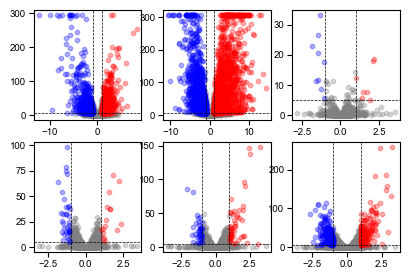

In [11]:
plt.rcParams['font.size'] = 7
plt.rcParams.update({'font.sans-serif':'Arial'})
params = {'mathtext.default': 'regular' }
plt.rcParams.update(params)
plt.rcParams['xtick.major.pad']= 2
plt.rcParams['ytick.major.pad']= 2
plt.rcParams['axes.labelpad']= 2

fig = plt.figure()

spec = fig.add_gridspec(nrows=2, ncols=3)

ax1 = fig.add_subplot(spec[0,0])
ax2 = fig.add_subplot(spec[0,1])
ax3 = fig.add_subplot(spec[0,2])
ax4 = fig.add_subplot(spec[1,0])
ax5 = fig.add_subplot(spec[1,1])
ax6 = fig.add_subplot(spec[1,2])

plot_volcano(SO_osc_vs_Control_degs, 1e-5, 2, 10, 0.5, ax1)
plot_volcano(O_osc_vs_Control_degs, 1e-5, 2, 10, 0.5, ax2)
plot_volcano(S_osc_vs_Control_degs, 1e-5, 2, 10, 0.5, ax3)
plot_volcano(S_osc_feast_vs_Control_degs, 1e-5, 2, 10, 0.5, ax4)
plot_volcano(S_osc_famine_vs_Control_degs, 1e-5, 2, 10, 0.5, ax5)
plot_volcano(S_osc_famine_vs_feast_degs, 1e-5, 2, 10, 0.5, ax6)

h=80/25.4
w=120/25.4
fig.set_size_inches(w=w,h=h)
plt.savefig("Volcano_figure_raw.svg", dpi=900);

# Plot PCA

In [10]:
rotated = pd.read_csv("../data/processed_RNA-seq_data/log_tpm_PCA_rotated.csv", index_col=0)
loadings = pd.read_csv("../data/processed_RNA-seq_data/log_tpm_PCA_loadings.csv", index_col=0)
metadata = pd.read_csv("../data/processed_RNA-seq_data/log_tpm_PCA_metadata.csv", index_col=0)
variances = pd.read_csv("../data/processed_RNA-seq_data/log_tpm_PCA_variances.csv", index_col=0)
variances

,variance
PC1,6.678288e+01
PC2,1.756818e+01
PC3,6.802511e+00
PC4,1.158400e+00
PC5,9.616771e-01
PC6,8.116623e-01
PC7,7.712028e-01
PC8,7.317835e-01
PC9,6.211441e-01
PC10,6.083435e-01


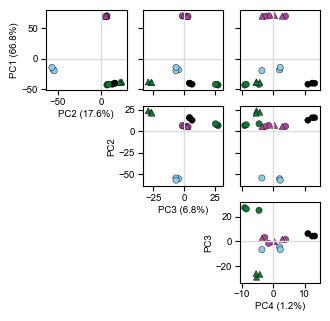

In [14]:
data = pd.concat([rotated, metadata], axis=1)

cb_B_1 = '#332288'
cb_B_2 = '#117733'
cb_B_3 = '#44AA99'
cb_B_4 = '#88CCEE'
cb_B_5 = '#DDCC77'
cb_B_6 = '#CC6677'
cb_B_7 = '#AA4499'
cb_B_8 = '#882255'
cb_B = [cb_B_1,cb_B_2,cb_B_3,cb_B_4,cb_B_5,cb_B_6,cb_B_7,cb_B_8]

cb_B = ["k", cb_B_2, cb_B_7, cb_B_4]

#     "O2 oscillations":cb_B_1,
#     "S & O2 oscillations":cb_B_4,
#     "S oscillations famine":cb_B_3,
#     "S oscillations feast":cb_B_2,
#     "Control":"black"  

plt.rcParams['font.size'] = 7
plt.rcParams.update({'font.sans-serif':'Arial'})
params = {'mathtext.default': 'regular' }
plt.rcParams.update(params)
plt.rcParams['xtick.major.pad']= 2
plt.rcParams['ytick.major.pad']= 2
plt.rcParams['axes.labelpad']= 2

fig = plt.figure()

spec = fig.add_gridspec(nrows=3, ncols=3)

ax1 = fig.add_subplot(spec[0,0])
ax2 = fig.add_subplot(spec[0,1])
ax3 = fig.add_subplot(spec[0,2])
ax4 = fig.add_subplot(spec[1,1])
ax5 = fig.add_subplot(spec[1,2])
ax6 = fig.add_subplot(spec[2,2])

### PC1 vs PC2
data = pd.concat([rotated, metadata], axis=1)

sns.scatterplot(
    data=data,
    y="rotated.PC1", 
    x="rotated.PC2",
    hue="metadata.oscillation",
    style="metadata.sample_ID",
    markers=["o","^"],
    linewidth=0.3,
    edgecolor="k",
    palette=cb_B,
    hue_order=["none", "S", "O", "S+O"],
    ax=ax1,
    s=20
)

ax1.get_legend().remove()

ax1.set_xlim(ax1.get_xlim()[0]*1.05,ax1.get_xlim()[1]*1.05)
ax1.set_ylim(ax1.get_ylim()[0]*1.05,ax1.get_ylim()[1]*1.05)
ax1.hlines(y=0,xmin=ax1.get_xlim()[0], xmax=ax1.get_xlim()[1], linewidths=1, colors="gainsboro")
ax1.vlines(x=0,ymin=ax1.get_ylim()[0], ymax=ax1.get_ylim()[1], linewidths=1, colors="gainsboro")

### PC1 vs PC3
data = pd.concat([rotated, metadata], axis=1)

sns.scatterplot(
    data=data,
    y="rotated.PC1", 
    x="rotated.PC3",
    hue="metadata.oscillation",
    style="metadata.sample_ID",
    markers=["o","^"],
    linewidth=0.3,
    edgecolor="k",
    palette=cb_B,
    hue_order=["none", "S", "O", "S+O"],
    ax=ax2,
    s=20
)

ax2.get_legend().remove()

ax2.set_xlim(ax2.get_xlim()[0]*1.05,ax2.get_xlim()[1]*1.05)
ax2.set_ylim(ax2.get_ylim()[0]*1.05,ax2.get_ylim()[1]*1.05)
ax2.hlines(y=0,xmin=ax2.get_xlim()[0], xmax=ax2.get_xlim()[1], linewidths=1, colors="gainsboro")
ax2.vlines(x=0,ymin=ax2.get_ylim()[0], ymax=ax2.get_ylim()[1], linewidths=1, colors="gainsboro")

### PC1 vs PC4
data = pd.concat([rotated, metadata], axis=1)

sns.scatterplot(
    data=data,
    y="rotated.PC1", 
    x="rotated.PC4",
    hue="metadata.oscillation",
    style="metadata.sample_ID",
    markers=["o","^"],
    linewidth=0.3,
    edgecolor="k",
    palette=cb_B,
    hue_order=["none", "S", "O", "S+O"],
    ax=ax3,
    s=20
)

ax3.get_legend().remove()

ax3.set_xlim(ax3.get_xlim()[0]*1.05,ax3.get_xlim()[1]*1.05)
ax3.set_ylim(ax3.get_ylim()[0]*1.05,ax3.get_ylim()[1]*1.05)
ax3.hlines(y=0,xmin=ax3.get_xlim()[0], xmax=ax3.get_xlim()[1], linewidths=1, colors="gainsboro")
ax3.vlines(x=0,ymin=ax3.get_ylim()[0], ymax=ax3.get_ylim()[1], linewidths=1, colors="gainsboro")

### PC2 vs PC3
data = pd.concat([rotated, metadata], axis=1)

sns.scatterplot(
    data=data,
    y="rotated.PC2", 
    x="rotated.PC3",
    hue="metadata.oscillation",
    style="metadata.sample_ID",
    markers=["o","^"],
    linewidth=0.3,
    edgecolor="k",
    palette=cb_B,
    hue_order=["none", "S", "O", "S+O"],
    ax=ax4,
    s=20
)

ax4.get_legend().remove()

ax4.set_xlim(ax4.get_xlim()[0]*1.05,ax4.get_xlim()[1]*1.05)
ax4.set_ylim(ax4.get_ylim()[0]*1.05,ax4.get_ylim()[1]*1.05)
ax4.hlines(y=0,xmin=ax4.get_xlim()[0], xmax=ax4.get_xlim()[1], linewidths=1, colors="gainsboro")
ax4.vlines(x=0,ymin=ax4.get_ylim()[0], ymax=ax4.get_ylim()[1], linewidths=1, colors="gainsboro")

### PC2 vs PC4
data = pd.concat([rotated, metadata], axis=1)

sns.scatterplot(
    data=data,
    y="rotated.PC2", 
    x="rotated.PC4",
    hue="metadata.oscillation",
    style="metadata.sample_ID",
    markers=["o","^"],
    linewidth=0.3,
    edgecolor="k",
    palette=cb_B,
    hue_order=["none", "S", "O", "S+O"],
    ax=ax5,
    s=20
)

ax5.get_legend().remove()

ax5.set_xlim(ax5.get_xlim()[0]*1.05,ax5.get_xlim()[1]*1.05)
ax5.set_ylim(ax5.get_ylim()[0]*1.05,ax5.get_ylim()[1]*1.05)
ax5.hlines(y=0,xmin=ax5.get_xlim()[0], xmax=ax5.get_xlim()[1], linewidths=1, colors="gainsboro")
ax5.vlines(x=0,ymin=ax5.get_ylim()[0], ymax=ax5.get_ylim()[1], linewidths=1, colors="gainsboro")

### PC3 vs PC4
data = pd.concat([rotated, metadata], axis=1)

sns.scatterplot(
    data=data,
    y="rotated.PC3", 
    x="rotated.PC4",
    hue="metadata.oscillation",
    style="metadata.sample_ID",
    markers=["o","^"],
    linewidth=0.3,
    edgecolor="k",
    palette=cb_B,
    hue_order=["none", "S", "O", "S+O"],
    ax=ax6,
    s=20
)

ax6.get_legend().remove()

ax6.set_xlim(ax6.get_xlim()[0]*1.05,ax6.get_xlim()[1]*1.05)
ax6.set_ylim(ax6.get_ylim()[0]*1.05,ax6.get_ylim()[1]*1.05)
ax6.hlines(y=0,xmin=ax6.get_xlim()[0], xmax=ax6.get_xlim()[1], linewidths=1, colors="gainsboro")
ax6.vlines(x=0,ymin=ax6.get_ylim()[0], ymax=ax6.get_ylim()[1], linewidths=1, colors="gainsboro")


ax1.set_ylabel("PC1 (66.8%)")
ax2.set_ylabel("")
ax3.set_ylabel("")
ax4.set_ylabel("PC2")
ax5.set_ylabel("")
ax6.set_ylabel("PC3")

ax1.set_xlabel("PC2 (17.6%)")
ax2.set_xlabel("")
ax3.set_xlabel("")
ax4.set_xlabel("PC3 (6.8%)")
ax5.set_xlabel("")
ax6.set_xlabel("PC4 (1.2%)")

ax2.set_yticklabels([])
ax3.set_yticklabels([])
ax5.set_yticklabels([])
ax2.set_xticklabels([])
ax3.set_xticklabels([])
ax5.set_xticklabels([])


h=90/25.4
w=90/25.4
fig.set_size_inches(w=w,h=h)
plt.savefig("PCA_Figure_raw.svg", dpi=900);

# Mapping of the central carbon metabolism and the ETC

In [40]:
O_osc_vs_Control_degs["contrast"] = "O_v_control"
S_osc_famine_vs_feast_degs["contrast"] = "S_famine_v_feast"
S_osc_vs_Control_degs["contrast"] = "S_v_control"
SO_osc_vs_Control_degs["contrast"] = "SO_v_control"
S_osc_famine_vs_Control_degs["contrast"] = "Famine_v_control"
S_osc_feast_vs_Control_degs["contrast"] = "Feast_v_control"

In [41]:
gene_name_list = [
    "ptsG",
    "crr",
    "glk",
    "pgi",
    "pgm",
    "pfkA",
    "pfkB",
    "fbp",
    "fbaA",
    "fbaB",
    "tpiA",
    "gapA",
    "pgk",
    "gpmA",
    "eno",
    "pykA",
    "pykF",
    "aceE",
    "aceF",
    "lpd",
    "pflB",
    "tdcE",
    "zwf",
    "pgl",
    "gnd",
    "rpiA",
    "rpiB",
    "rpe",
    "tktA",
    "tktB",
    "talA",
    "talB",
    "edd",
    "eda",
    "gltA",
    "prpC",
    "acnA",
    "acnB",
    "icd",
    "sucA",
    "sucB",
    "sucC",
    "sucD",
    "sdhA",
    "sdhB",
    "sdhC",
    "sdhD",
    "frdA",
    "frdB",
    "frdC",
    "frdD",
    "fumA",
    "fumB",
    "fumC",
    "mdh",
    "aceA",
    "aceB",
    "ppc",
    "pck",
    "maeA",
    "maeB",
    "ppsA",
    "pta",
    "ackA",
    "mgsA",
    "arcA",
    "arcB",
    "cra",
    "crp",
    "fnr",
    "mlc",
    "iclR",
    "fur",
    "pdhR",
    "ihfA",
    "ihfB"
]

In [42]:
gene_id_list = []
for gene in gene_name_list:
    gene_id_list.append(ica_data.name2num(gene))

In [43]:
df = pd.concat([O_osc_vs_Control_degs,S_osc_famine_vs_feast_degs,S_osc_vs_Control_degs,SO_osc_vs_Control_degs,S_osc_famine_vs_Control_degs,S_osc_feast_vs_Control_degs])
df = df.loc[gene_id_list]
df["mask"] = (df["padj"] > 10e-5) & ((df["log2FoldChange"] < 1) | (df["log2FoldChange"] > -1))

In [44]:
df

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,contrast,mask
b1101,2936.397401,-0.469228,0.110395,-4.250438,2.133531e-05,2.870557e-05,O_v_control,False
b1101,2936.397401,-0.342723,0.082050,-4.177029,2.953411e-05,8.681785e-05,S_famine_v_feast,False
b1101,2936.397401,0.563903,0.109585,5.145828,2.663436e-07,2.621669e-05,S_v_control,False
b1101,2936.397401,-1.536054,0.128414,-11.961750,5.636116e-33,5.881932e-32,SO_v_control,False
b1101,2936.397401,0.382085,0.082488,4.631992,3.621643e-06,2.044880e-05,Famine_v_control,False
...,...,...,...,...,...,...,...,...
b0912,2322.856665,0.320834,0.102789,3.121303,1.800525e-03,4.088240e-03,S_famine_v_feast,True
b0912,2322.856665,-0.081281,0.121041,-0.671518,5.018904e-01,9.361178e-01,S_v_control,True
b0912,2322.856665,-0.141172,0.139932,-1.008861,3.130414e-01,3.862628e-01,SO_v_control,True
b0912,2322.856665,0.070539,0.102690,0.686909,4.921398e-01,6.226536e-01,Famine_v_control,True


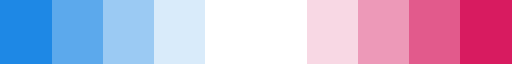

In [45]:
red = '#D81B60'
blue = '#1E88E5'

cmap1 = mpl.colors.LinearSegmentedColormap.from_list(
    name="custom", 
    colors=[(0,blue), (0.4,"white"), (0.6,"white"), (1,red)],
    N=10
)
cmap1

In [46]:
new_index = []
for gene in df.index:
    new_index.append(ica_data.num2name(gene))
df.index = new_index

In [48]:
p_value = df.pivot(values="padj", columns="contrast")
data = df.pivot(values="log2FoldChange", columns="contrast")
mask = df.pivot(values="mask", columns="contrast")

In [49]:
data

contrast,Famine_v_control,Feast_v_control,O_v_control,SO_v_control,S_famine_v_feast,S_v_control
aceA,0.388255,-0.123006,-0.200217,-0.163951,0.511262,0.155132
aceB,0.316461,0.179518,0.456835,0.818377,0.136943,0.249570
aceE,0.450019,-0.219721,4.507943,1.850077,0.669739,0.153532
aceF,0.822427,-0.231231,4.445551,1.605823,1.053658,0.389577
ackA,0.434910,0.211476,-1.337531,-0.739232,0.223434,0.327126
...,...,...,...,...,...,...
tdcE,0.235920,0.343737,5.922557,0.587455,-0.107816,0.294116
tktA,-0.236295,0.119068,-4.475849,-1.216595,-0.355364,-0.047391
tktB,0.476301,0.185591,-4.769839,-0.155449,0.290710,0.338139
tpiA,0.062318,0.089772,-2.563390,-0.631890,-0.027453,0.076164


In [25]:
data = data[["SO_v_control", "O_v_control", "Feast_v_control", "Famine_v_control", "S_famine_v_feast"]]
p_value = p_value[["SO_v_control", "O_v_control", "Feast_v_control", "Famine_v_control", "S_famine_v_feast"]]
mask = mask[["SO_v_control", "O_v_control", "Feast_v_control", "Famine_v_control", "S_famine_v_feast"]]

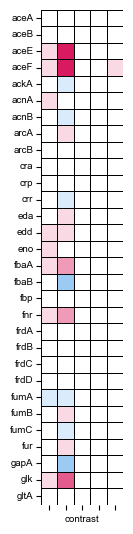

In [27]:
fig, ax = plt.subplots()

sns.heatmap(
    data=data[:30],
    cmap=cmap1,
    center=0,
    mask=mask[:30],
    vmin=-5,
    vmax=5,
    linecolor="k",
    linewidths=0.5,
    ax=ax,
    cbar=False
)

# ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.set_xticklabels([])

w=27/25.4
h=400/76*31/25.4
fig.set_size_inches(w=w,h=h)

plt.savefig("genes_1.svg")

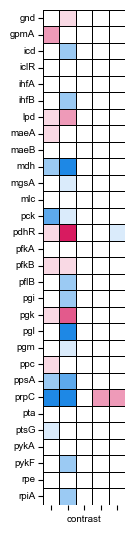

In [29]:
fig, ax = plt.subplots()

sns.heatmap(
    data=data[30:60],
    cmap=cmap1,
    center=0,
    mask=mask[30:60],
    vmin=-5,
    vmax=5,
    linecolor="k",
    linewidths=0.5,
    ax=ax,
    cbar=False
)

# ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.set_xticklabels([])

w=27/25.4
h=400/76*31/25.4
fig.set_size_inches(w=w,h=h)

plt.savefig("genes_2.svg")

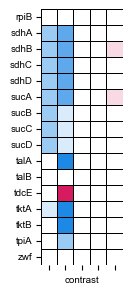

In [31]:
fig, ax = plt.subplots()

sns.heatmap(
    data=data[60:],
    cmap=cmap1,
    center=0,
    mask=mask[60:],
    vmin=-5,
    vmax=5,
    linecolor="k",
    linewidths=0.5,
    ax=ax,
    cbar=False
)

ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
ax.set_xticklabels([])

w=27/25.4
h=400/76*16/25.4
fig.set_size_inches(w=w,h=h)

plt.savefig("genes_3.svg")

In [72]:
gene_name_list = [
    "nuoA",
    "nuoB",
    "nuoC",
    "nuoE",
    "nuoF",
    "nuoG",
    "nuoH",
    "nuoI",
    "nuoJ",
    "nuoK",
    "nuoL",
    "nuoM",
    "nuoN",
    "ndh",
    "cyoA",
    "cyoB",
    "cyoC",
    "cyoD",
    "cyoE",
    "cydA",
    "cydB",
    "cydC",
    "cydD",
    "appB",
    "appC"
]

In [73]:
gene_id_list = []
for gene in gene_name_list:
    gene_id_list.append(ica_data.name2num(gene))

In [74]:
df = pd.concat([O_osc_vs_Control_degs,S_osc_famine_vs_feast_degs,S_osc_vs_Control_degs,SO_osc_vs_Control_degs,S_osc_famine_vs_Control_degs,S_osc_feast_vs_Control_degs])
df = df.loc[gene_id_list]
df["mask"] = df["padj"] > 10e-5

In [75]:
new_index = []
for gene in df.index:
    new_index.append(ica_data.num2name(gene))
df.index = new_index

In [76]:
p_value = df.pivot(values="padj", columns="contrast")
data = df.pivot(values="log2FoldChange", columns="contrast")
mask = df.pivot(values="mask", columns="contrast")

In [77]:
data = data[["SO_v_control", "O_v_control", "Feast_v_control", "Famine_v_control", "S_famine_v_feast"]]
p_value = p_value[["SO_v_control", "O_v_control", "Feast_v_control", "Famine_v_control", "S_famine_v_feast"]]
mask = mask[["SO_v_control", "O_v_control", "Feast_v_control", "Famine_v_control", "S_famine_v_feast"]]

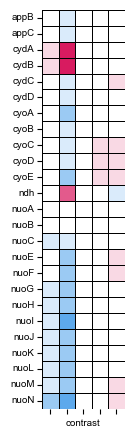

In [39]:
fig, ax = plt.subplots()

sns.heatmap(
    data=data,
    cmap=cmap1,
    center=0,
    mask=mask,
    vmin=-5,
    vmax=5,
    linecolor="k",
    linewidths=0.5,
    ax=ax,
    cbar=False
)

# ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.set_xticklabels([])

w=27/25.4
h=400/76*25/25.4
fig.set_size_inches(w=w,h=h)

plt.savefig("genes_etc.svg")